In [1]:
import numpy as np

import pandas as pd

import sklearn



def generateDataset(size, ndim=4):

    bias=1

    x = np.linspace(-2*np.pi, +2*np.pi, size)

    timeSeries=4*np.sin(x)+bias

    features=np.zeros((size, ndim))

    labels=np.zeros((size, 1))

    for i in range(size):

        for j in range(ndim):

            features[i,j]=np.random.random_sample()*10

        if np.linalg.norm(features[i])>8:

            labels[i]=1

    return timeSeries, features, labels


timeSeries, features, labels = generateDataset(1000)



################## Your Code Here ##########################


################## First question ##########################

#Visualize the data, either using pandas ploting capability 

#or matplotlib.

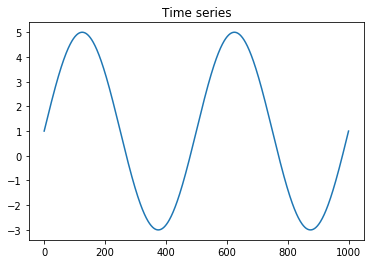

<Figure size 432x288 with 0 Axes>

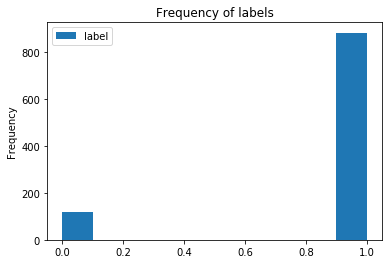

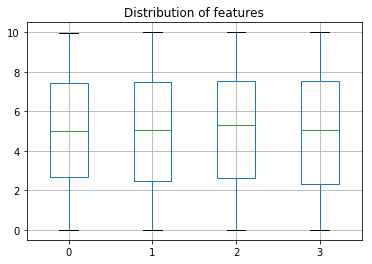

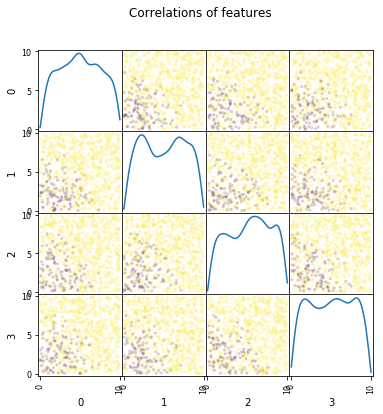

In [7]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

timeSeriesPd = pd.Series(timeSeries)
featuresPd = pd.DataFrame(features)
labelsPd = pd.DataFrame(labels, columns=['label'])

# Raw time series
plt.figure()
plt.title('Time series')
timeSeriesPd.plot()

# Frequency of labels
plt.figure()
labelsPd.plot(kind='hist', title='Frequency of labels')

# distribution of features
plt.figure()
plt.title('Distribution of features')
featuresPd.boxplot()

# correlation of features
scatter_matrix(featuresPd, alpha=0.2, figsize=(6, 6), diagonal='kde', c = labels.transpose()[0])
plt.suptitle('Correlations of features')
plt.show()


################## Second question ########################

#Preprocess the data so it is suited for ML analysis.

#Specifically it is desired to have Train and Validation

#Datasets with 75/25 weight.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

# we scale the features to be in the range [0-1]
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
scaler.fit(features)
scaledFeatures = scaler.transform(features)
scaledFeaturesPd = pd.DataFrame(scaledFeatures)

# we create the dataset containing both preprocessed features and outputs
scaleddataset=pd.concat([scaledFeaturesPd,labelsPd], axis=1)
dsTrain, dsTest = train_test_split(scaleddataset, test_size=0.25)


# we oversample the get roughly the same amount of positive and negative samples

count0 = dsTrain.label.value_counts()[0.0]
count1 = dsTrain.label.value_counts()[1.0]

dsTrain0 = dsTrain[dsTrain['label'] == 0]
dsTrain1 = dsTrain[dsTrain['label'] == 1]

# we also take each sample 3 times to have enough training data
dsTrain1Small = pd.concat([dsTrain1,dsTrain1,dsTrain1])
print('Imbalance ratio : ' + str(int(count1/count0)))
for i in range(0, 3*int(count1/count0)):
    dsTrain1Small = pd.concat([dsTrain0, dsTrain1Small], axis=0)
dsTrainSmall = dsTrain1Small

# we shuffle the trainig set
dsTrainFinal = shuffle(dsTrainSmall)
dsTestFinal = dsTest  # This line is just there for consistency.


Imbalance ratio : 6


################## Third question ##########################

#Using Principal Analysis Decomposition, reduce the 

#dimensionality of the features to ndim=2. Then apply an

#MLP classifier on the new features and the original labels

#MLP characteristics are 3 hidden layers of 25 cells and 

#sigmoid activation. Evaluate the model

[[ 18   2]
 [ 10 220]]


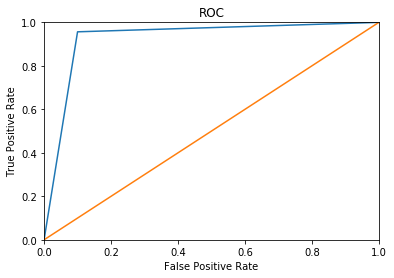

AUC = 0.9282608695652175


In [9]:
from sklearn import decomposition
from sklearn.metrics import classification_report,confusion_matrix

# PCA

dsTrainFeaturesFinal = dsTrainFinal[dsTrainFinal.columns[:-1]]  # we only keep features
dsTestFeaturesFinal = dsTestFinal[dsTestFinal.columns[:-1]]  # we only keep features
pca = decomposition.PCA(n_components=2)
pca.fit(dsTrainFeaturesFinal)
newTrainFeaturesFinal = pca.transform(dsTrainFeaturesFinal)
newTestFeaturesFinal = pca.transform(dsTestFeaturesFinal)

# MLP

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve

dsTrainLabelsFinal = dsTrainFinal[dsTrainFinal.columns[-1]]  # we only keep labels
dsTestLabelsFinal = dsTestFinal[dsTestFinal.columns[-1]]  # we only keep labels

mlp = MLPClassifier(hidden_layer_sizes=(25,25,25),max_iter=500,activation='logistic')  # we create the MLP
mlp.fit(newTrainFeaturesFinal,dsTrainLabelsFinal)   # we train the MLP

#evaluation
predictions = mlp.predict(newTestFeaturesFinal)   # we first predict the labels of the test dataset

#we print the confusion matrix
print(confusion_matrix(dsTestLabelsFinal,predictions))

fpr, tpr, threshold = roc_curve(dsTestLabelsFinal,predictions)
plt.title('ROC')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#we print the area under curve
print('AUC = ' + str(roc_auc_score(dsTestLabelsFinal,predictions)))

In [10]:
################## Fourth question #########################

#Create a model to predict future steps of the timeSeries

#Please only use scikitLearn methods even though sub-optimal

#Justify the model selection and accuracy

The best model has a window size of : 6
The best model has a root mean square error of : 0.0012620104913841092


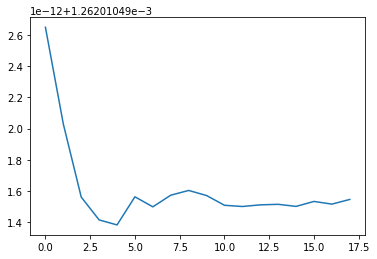

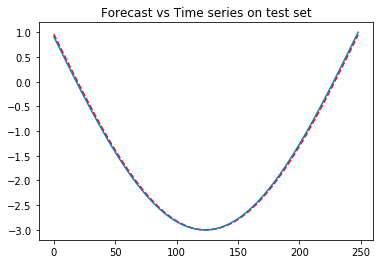

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()

tsTrainTestSplit = int(len(timeSeries)*0.75)

def sliding_window(a, window_size):
    l = []
    for i in range(0, len(a)-window_size):
        l.append(a[i:(i+window_size)].reshape(-1,1))
    return np.concatenate(l, axis=1).transpose(), a[window_size:]

def forecast(a, window_size, split_point):
    x,y=sliding_window(a[0:split_point],window_size)
    lr.fit(x,y)
    last_window = np.concatenate([x[-1][1:],y[-1:]]).reshape(-1,1).transpose()
    forecast = []
    for i in range(split_point+1, len(a)):
        # predict one step and update the sliding window with the new value
        last_window=np.concatenate([last_window[-1][1:],lr.predict(last_window[-1:])]).reshape(-1,1).transpose()
        # record the result
        forecast.append(last_window[0][-1])
    return forecast
    
def forecast_rmse(a, window_size, split_point):
    result = forecast(a, window_size, split_point)
    return result,mean_squared_error(result, a[(split_point+1):])

# model selection
rmseList = []
for size in range(2,20):
    result,rmse = forecast_rmse(timeSeries, size, tsTrainTestSplit)
    rmseList.append(rmse)

# Display of the RMSE errors curve
plt.figure()
pd.Series(rmseList).plot()

# we select the window size with the lowest root mean square 
bestWindowSize = np.argmin(rmseList)+2
print('The best model has a window size of : ' + str(bestWindowSize))

result,rmse = forecast_rmse(timeSeries, bestWindowSize, tsTrainTestSplit)
print('The best model has a root mean square error of : ' + str(rmse))

# Visual comparison of the predictino and the reel curve
plt.figure()
plt.title('Forecast vs Time series on test set')
forecastPd = pd.Series(result)
forecastPd.plot(style='r--')
pd.Series(timeSeries[(tsTrainTestSplit+1):]).plot()